In [2]:
library(dplyr)
library(tidyr)
library(tidyverse)
library(sf)
library(MatchIt)
library(fixest)
install.packages("cobalt")
library(cobalt)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.1     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.1.8
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1; sf_use_s2() is TRUE

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘chk’


 cobalt (Version 4.5.1, Build Date: 2023-04-27)


Attaching package: ‘cobalt’


The following object is masked from ‘package:

## 1. Add Tree Loss

In [3]:
# Load matching frame
mf = st_read(file.path("/kaggle/input/mf-rbase-1km-mdg/mf_rBase_1km_Madagascar.gpkg")) %>%
  filter(group==0 | group==1) %>%
  st_drop_geometry()

Reading layer `mf_rBase_1km_Madagascar' from data source 
  `/kaggle/input/mf-rbase-1km-mdg/mf_rBase_1km_Madagascar.gpkg' 
  using driver `GPKG'
Simple feature collection with 591917 features and 29 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 313074.7 ymin: 7167908 xmax: 1089075 ymax: 8675908
Projected CRS: WGS 84 / UTM zone 38S


In [52]:
head(mf)

,gridID,group,wdpaid,fc_._2000,fc_._2001,fc_._2002,fc_._2003,fc_._2004,fc_._2005,fc_._2006,⋯,treeloss_pct_2013,treeloss_pct_2014,treeloss_pct_2015,treeloss_pct_2016,treeloss_pct_2017,treeloss_pct_2018,treeloss_pct_2019,treeloss_pct_2020,treeloss_pct_2021,avgLoss_pre_fund
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,85,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯,0.0,0,0,0,0,0,0,0,0,0
2,86,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯,0.0,0,0,0,0,0,0,0,0,0
3,87,0,0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,⋯,0.0,0,0,0,0,0,0,0,0,0
4,88,0,0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,⋯,0.0,0,0,0,0,0,0,0,0,0
5,89,0,0,0.4,0.4,0.4,0.4,0.4,0.4,0.4,⋯,0.1,0,0,0,0,0,0,0,0,0
6,90,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯,0.0,0,0,0,0,0,0,0,0,0


In [4]:
# The calculation of tree loss area is performed at dataframe base
# Get the column names of tree cover time series
colnames_tree = names(mf)[startsWith(names(mf), "fc")]
# Drop the first year
dropFirst = tail(colnames_tree, -1)
# Drop the last year
dropLast = head(colnames_tree, -1)
# Set list of new column names for tree loss time series
colnames_loss = dropFirst %>% str_split(., "_")
# Add new columns: treeloss_tn = treecover_tn - treecover_t(n-1)  
for (i in 1:length(dropFirst)) {
  new_colname <- paste0("treeloss_pct_", colnames_loss[[i]][3])
    # Calc absolute value of Year_t - Year_(t-1) 
  mf[[new_colname]] <- abs(mf[[dropFirst[i]]] - mf[[dropLast[i]]])
}

In [5]:
# Add column: average treeloss before funding starts, i.e. avg. of treeloss from 2001 to 2006
mf$avgLoss_pre_fund = round(rowMeans(mf[grepl("treeloss", names(mf))][1:6]), 2)

## 2a. Matching

* Good Balance when,
`Std. Mean Diff` and `eCDF stats` close to **`0`** and `variance ratios` close to **`1`**.

* `Std.Pair Diff` displays the average absolute within-pair difference of each covariate. when they're small, better balance, and estimated effects are more robust to misspecification of the outcome model.

In [6]:
# Make cut-off list ####
lst_cutoffs = c()

# Quantile in 8 parts
lst_cutoffs$accessiblity_min = as.integer(quantile(mf$accessiblity_min, probs = seq(0, 1, 0.05), na.rm=TRUE))

#lst_cutoffs$clay_._mean_0_20 = as.integer(quantile(mf$clay_._mean_0_20, probs = seq(0, 1, 0.05), na.rm=TRUE))
lst_cutoffs$clay_._mean_0_20 = as.integer(c(0,10,20,30, 32,34,36,38,40, 50,60,70,80,90,100))

lst_cutoffs$elevation_m = as.integer(quantile(mf$elevation_m, probs = seq(0, 1, 0.1), na.rm=TRUE))

lst_cutoffs$TRI = as.integer(quantile(mf$TRI, probs = seq(0, 1, 0.1), na.rm=TRUE))

lst_cutoffs$fc_._2000 = as.integer(quantile(mf$fc_._2000, probs = seq(0, 1, 0.025), na.rm=TRUE))

lst_cutoffs$avgLoss_pre_fund = as.integer(quantile(mf$avgLoss_pre_fund, probs = seq(0, 1, 0.005), na.rm=TRUE))

In [7]:
# CEM Match
out.cem = matchit(group ~ accessiblity_min + clay_._mean_0_20 +
                   
                   elevation_m + TRI + 
                   
                   fc_._2000 + avgLoss_pre_fund,
                 
                 data = mf, method = "cem", cutpoints = lst_cutoffs)

In [ ]:
# Summary of matching output
summary(out.cem)

## 2b. Plot Covariate Balance

Reference: https://cloud.r-project.org/web/packages/cobalt/vignettes/cobalt.html#bal.plot

In [31]:
c_name = data.frame(old = c("accessiblity_min", "clay_._mean_0_20", "elevation_m",
                            "TRI", "fc_._2000", "avgLoss_pre_fund"),
                    new = c("Accessibility", "Clay Content", "Elevation",
                            "TRI", "Forest Cover in 2000", "Avg. Annual Forest \n Loss 2001 ~ 2006"))

In [32]:
p_covBal = love.plot(out.cem, 
                     binary = "std", 
                     abs = TRUE,
                     #thresholds = c(m = .1),
                     var.order = "unadjusted",
                     var.names = c_name,
                     sample.names = c("Discarded", "Selected"),
                     wrap = 25 # at how many characters does axis label break to new line
                    )

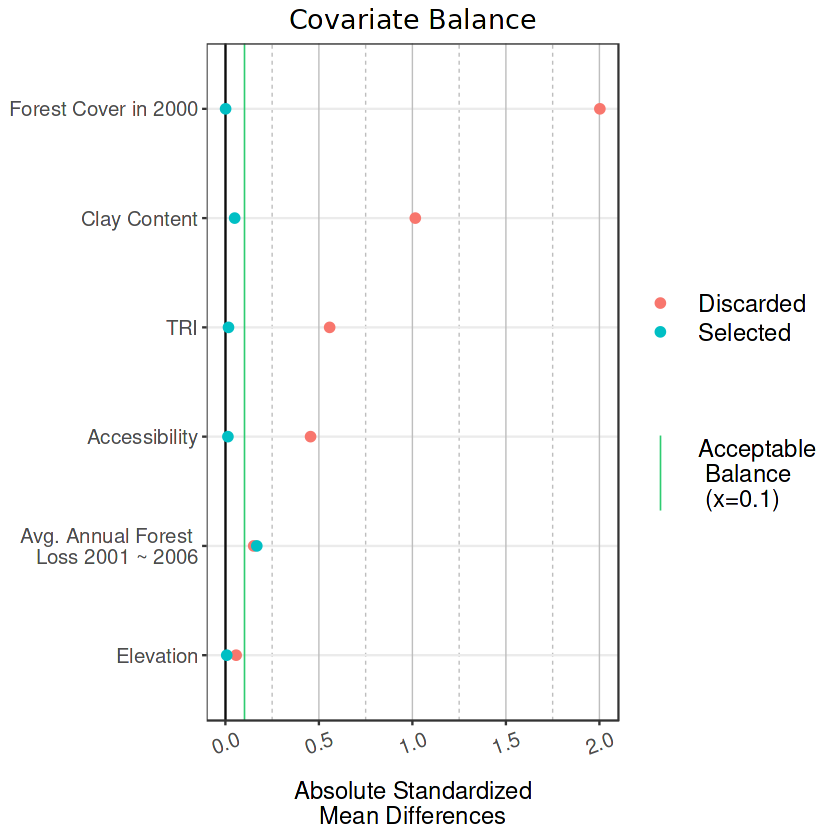

In [41]:
p_covBal + 
    geom_vline(aes(xintercept=0.1, linetype="Acceptable \n Balance \n (x=0.1)"), color="#2ecc71", linewidth=0.35) +
    theme_bw() +
    theme(
        plot.title = element_text(family="Arial Black", size=16, hjust=0.5),
        
        legend.title = element_blank(),
        legend.text=element_text(size=14),
        legend.spacing.x = unit(0.5, 'cm'),
        legend.spacing.y = unit(0.75, 'cm'),
        
        axis.text.x = element_text(angle = 20, hjust = 0.5, vjust = 0.5),
        axis.text=element_text(size=12),
        axis.title=element_text(size=14),
        axis.title.y = element_text(margin = margin(unit = 'cm', r = 0.5)),
        axis.title.x = element_text(margin = margin(unit = 'cm', t = 0.5)),
        
        panel.grid.major.x = element_line(color = 'grey', linewidth = 0.3, linetype = 1),
        panel.grid.minor.x = element_line(color = 'grey', linewidth = 0.3, linetype = 2)
    ) + guides(linetype = guide_legend(override.aes = list(color = "#2ecc71"))) # Add legend for geom_vline


After "matching", the selected treatment and control observations present largely reduced absolute standardized mean differences, implying an improved balance.

## 2c. Plot Histogramm

**Black line --> Treatment, Grey line --> Control**

In [8]:
fnl = c(`Unadjusted Sample` = "Before Matching",
        `Adjusted Sample` = "After Matching")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


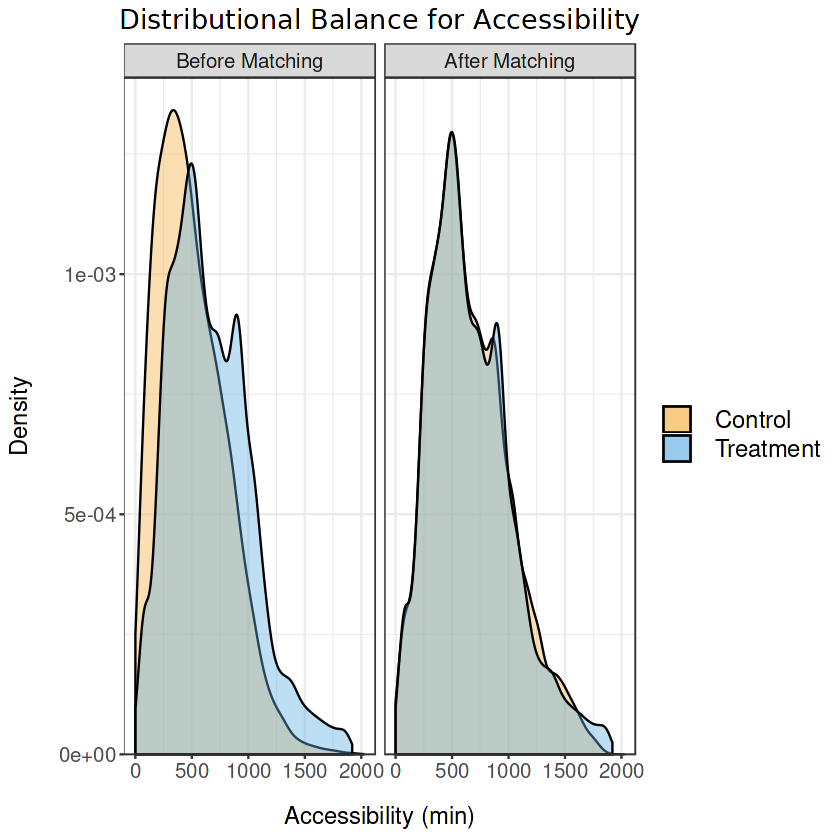

In [44]:
p_travel = bal.plot(out.cem, 
                    var.name = "accessiblity_min",
                    #sample.names = c("Control", "Treatment"),
                    which = "both")

p_travel +
    facet_wrap(.~which, labeller = as_labeller(fnl)) +
    #scale_fill_viridis(discrete = T) +
    scale_fill_manual(labels = c("Control", "Treatment"), values = c("#f5b041","#5dade2")) +
    labs(title = "Distributional Balance for Accessibility",
         x = "Accessibility (min)",
         fill = "Group") +
    theme_bw() +
    theme(
        plot.title = element_text(family="Arial Black", size=16, hjust=0.5),
        
        legend.title = element_blank(),
        legend.text=element_text(size=14),
        legend.spacing.x = unit(0.5, 'cm'),
        legend.spacing.y = unit(0.75, 'cm'),
        
        axis.text=element_text(size=12),
        axis.title=element_text(size=14),
        axis.title.y = element_text(margin = margin(unit = 'cm', r = 0.5)),
        axis.title.x = element_text(margin = margin(unit = 'cm', t = 0.5)),
        
        strip.text.x = element_text(size = 12) # Facet Label
    )

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


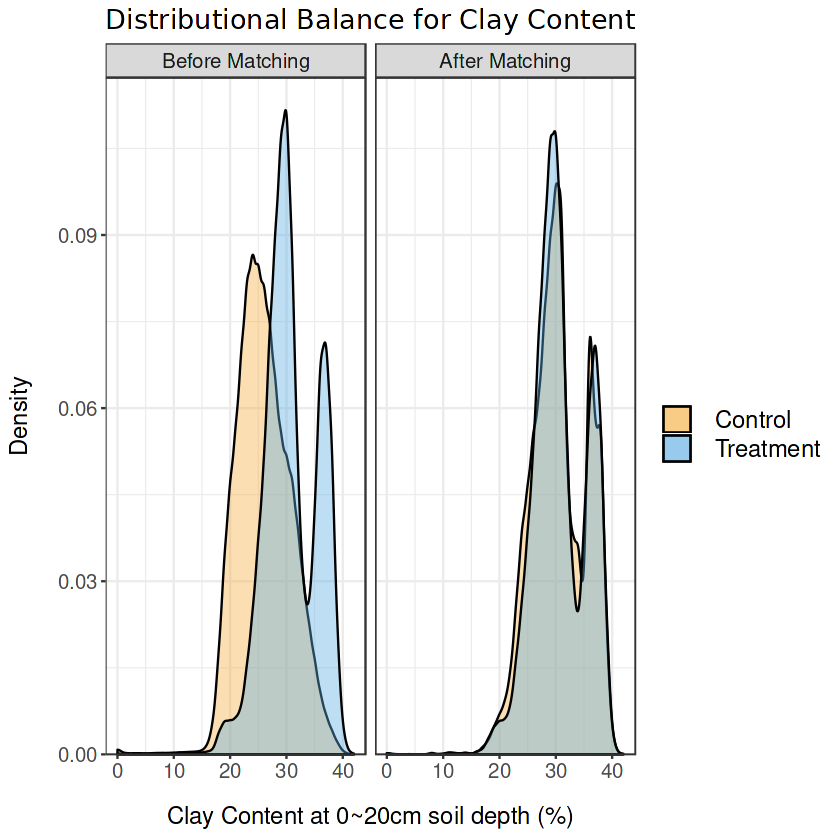

In [45]:
p_clay = bal.plot(out.cem, 
                    var.name = "clay_._mean_0_20",
                    which = "both")

p_clay +
    facet_wrap(.~which, labeller = as_labeller(fnl)) +
    #scale_fill_viridis(discrete = T) +
    scale_fill_manual(labels = c("Control", "Treatment"), values = c("#f5b041","#5dade2")) +
    labs(title = "Distributional Balance for Clay Content",
         x = "Clay Content at 0~20cm soil depth (%)",
         fill = "Group") +
    theme_bw() +
    theme(
        plot.title = element_text(family="Arial Black", size=16, hjust=0.5),
        
        legend.title = element_blank(),
        legend.text=element_text(size=14),
        legend.spacing.x = unit(0.5, 'cm'),
        legend.spacing.y = unit(0.75, 'cm'),
        
        axis.text=element_text(size=12),
        axis.title=element_text(size=14),
        axis.title.y = element_text(margin = margin(unit = 'cm', r = 0.5)),
        axis.title.x = element_text(margin = margin(unit = 'cm', t = 0.5)),
        
        strip.text.x = element_text(size = 12) # Facet Label
    )

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


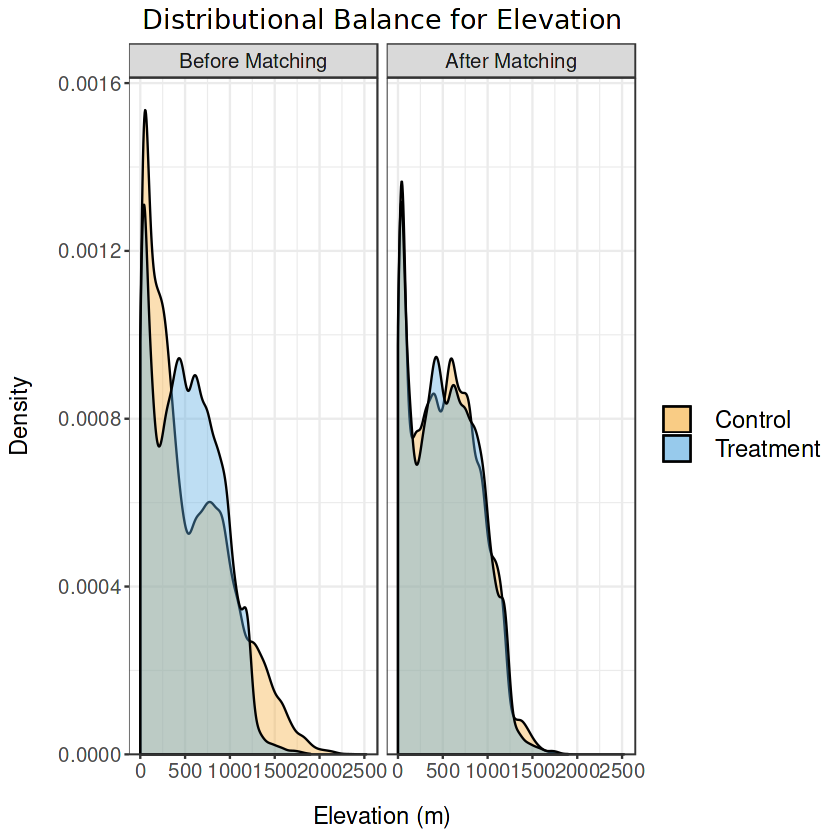

In [46]:
p_elevation = bal.plot(out.cem, 
                    var.name = "elevation_m",
                    which = "both")

p_elevation +
    facet_wrap(.~which, labeller = as_labeller(fnl)) +
    #scale_fill_viridis(discrete = T) +
    scale_fill_manual(labels = c("Control", "Treatment"), values = c("#f5b041","#5dade2")) +
    labs(title = "Distributional Balance for Elevation",
         x = "Elevation (m)",
         fill = "Group") +
    theme_bw() +
    theme(
        plot.title = element_text(family="Arial Black", size=16, hjust=0.5),
        
        legend.title = element_blank(),
        legend.text=element_text(size=14),
        legend.spacing.x = unit(0.5, 'cm'),
        legend.spacing.y = unit(0.75, 'cm'),
        
        axis.text=element_text(size=12),
        axis.title=element_text(size=14),
        axis.title.y = element_text(margin = margin(unit = 'cm', r = 0.5)),
        axis.title.x = element_text(margin = margin(unit = 'cm', t = 0.5)),
        
        strip.text.x = element_text(size = 12) # Facet Label
    )

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


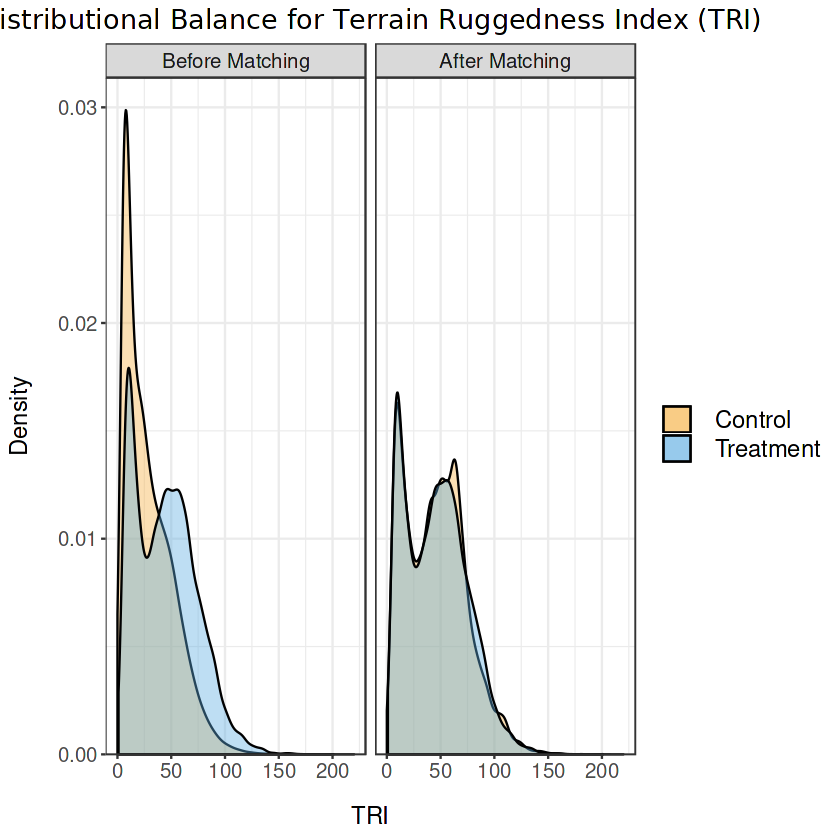

In [47]:
p_tri = bal.plot(out.cem, 
                    var.name = "TRI",
                    which = "both")

p_tri +
    facet_wrap(.~which, labeller = as_labeller(fnl)) +
    #scale_fill_viridis(discrete = T) +
    scale_fill_manual(labels = c("Control", "Treatment"), values = c("#f5b041","#5dade2")) +
    labs(title = "Distributional Balance for Terrain Ruggedness Index (TRI)",
         x = "TRI",
         fill = "Group") +
    theme_bw() +
    theme(
        plot.title = element_text(family="Arial Black", size=16, hjust=0.5),
        
        legend.title = element_blank(),
        legend.text=element_text(size=14),
        legend.spacing.x = unit(0.5, 'cm'),
        legend.spacing.y = unit(0.75, 'cm'),
        
        axis.text=element_text(size=12),
        axis.title=element_text(size=14),
        axis.title.y = element_text(margin = margin(unit = 'cm', r = 0.5)),
        axis.title.x = element_text(margin = margin(unit = 'cm', t = 0.5)),
        
        strip.text.x = element_text(size = 12) # Facet Label
    )

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


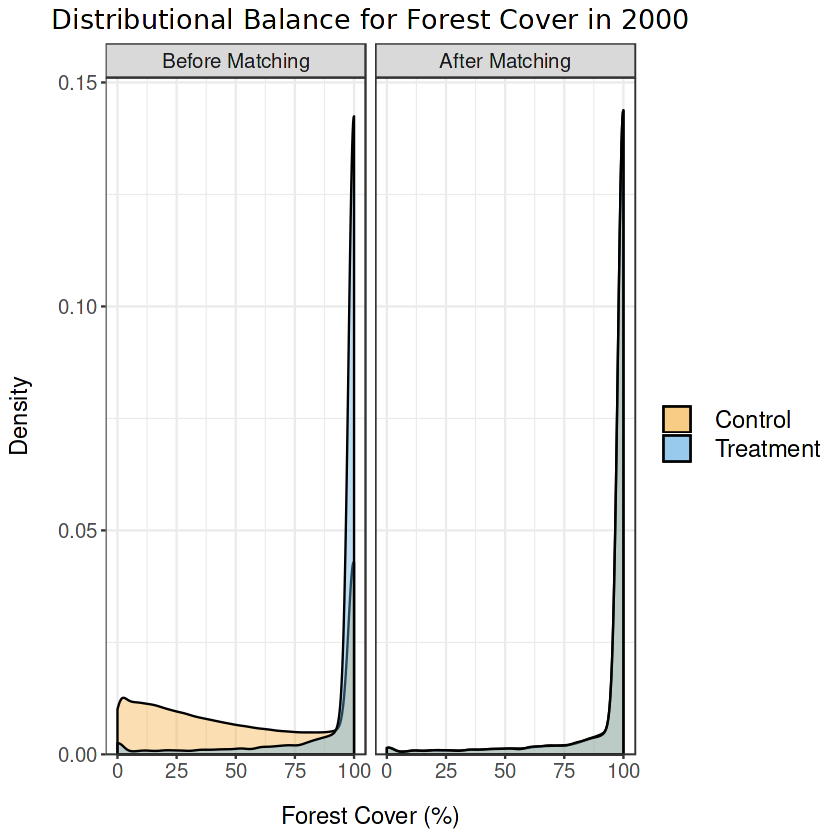

In [49]:
p_fc = bal.plot(out.cem, 
                    var.name = "fc_._2000",
                    which = "both")

p_fc +
    facet_wrap(.~which, labeller = as_labeller(fnl)) +
    #scale_fill_viridis(discrete = T) +
    scale_fill_manual(labels = c("Control", "Treatment"), values = c("#f5b041","#5dade2")) +
    labs(title = "Distributional Balance for Forest Cover in 2000",
         x = "Forest Cover (%)",
         fill = "Group") +
    theme_bw() +
    theme(
        plot.title = element_text(family="Arial Black", size=16, hjust=0.5),
        
        legend.title = element_blank(),
        legend.text=element_text(size=14),
        legend.spacing.x = unit(0.5, 'cm'),
        legend.spacing.y = unit(0.75, 'cm'),
        
        axis.text=element_text(size=12),
        axis.title=element_text(size=14),
        axis.title.y = element_text(margin = margin(unit = 'cm', r = 0.5)),
        axis.title.x = element_text(margin = margin(unit = 'cm', t = 0.5)),
        
        strip.text.x = element_text(size = 12) # Facet Label
    )

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


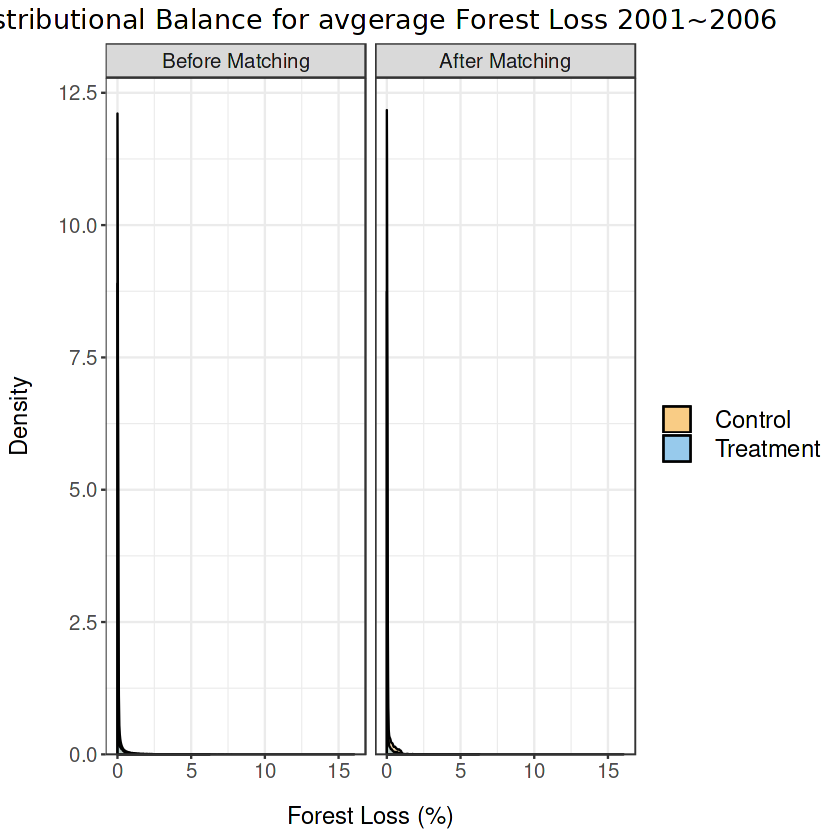

In [51]:
p_fl = bal.plot(out.cem, 
                    var.name = "avgLoss_pre_fund",
                    which = "both")

p_fl +
    facet_wrap(.~which, labeller = as_labeller(fnl)) +
    #scale_fill_viridis(discrete = T) +
    scale_fill_manual(labels = c("Control", "Treatment"), values = c("#f5b041","#5dade2")) +
    labs(title = "Distributional Balance for avgerage Forest Loss 2001~2006",
         x = "Forest Loss (%)",
         fill = "Group") +
    theme_bw() +
    theme(
        plot.title = element_text(family="Arial Black", size=16, hjust=0.5),
        
        legend.title = element_blank(),
        legend.text=element_text(size=14),
        legend.spacing.x = unit(0.5, 'cm'),
        legend.spacing.y = unit(0.75, 'cm'),
        
        axis.text=element_text(size=12),
        axis.title=element_text(size=14),
        axis.title.y = element_text(margin = margin(unit = 'cm', r = 0.5)),
        axis.title.x = element_text(margin = margin(unit = 'cm', t = 0.5)),
        
        strip.text.x = element_text(size = 12) # Facet Label
    )

In [ ]:
# Plot ####
#plot(out.cem, type = "density", interactive = FALSE,
#     which.xs = c("accessiblity_min", "clay_._mean_0_20", "elevation_m"))
#plot(out.cem, type = "density", interactive = FALSE,
#     which.xs = c("TRI", "fc_._2000", "avgLoss_pre_fund"))

## 3. Panelize Matched Dataframe

In [ ]:
# Pivot DF of matched objects
matched.wide = match.data(object=out.cem, data=mf)
print(paste0("The total number of matched items: ", as.character(nrow(matched.wide))))

head(matched.wide)

In [ ]:
# Average treecover 2000 of matched treatment group, identical with CEM summary
matched.wide %>%
    filter(group==1) %>% select(c(fc_._2000)) %>%
    summarise(across(everything(), mean))

In [ ]:
# Average treecover 2000 of matched control group, NOT identical with CEM summary!
matched.wide %>%
    filter(group==0) %>% select(c(fc_._2000)) %>%
    summarise(across(everything(), mean))

In [ ]:
# Pivot Wide ==> Pivot Long
matched.long = matched.wide %>%
    select(c(group, wdpaid, gridID, weights, starts_with("fc"))) %>%
    pivot_longer(cols = c(starts_with("fc")),
                 names_to = c("var", "year"),
                 names_sep = "_._",
                 values_to = "fc_pct")

In [ ]:
head(matched.long)

## 4. Plotting

In [ ]:
# DF for plotting Trend
df_plotTrend = matched.long %>%
    group_by(group, year) %>%
    summarise(fc_avg = mean(fc_pct, na.rm=TRUE), n = n())
df_plotTrend

In [ ]:
# Trend Plot
ggplot(df_plotTrend, 
       aes(x = year, y = fc_avg)) +
    geom_line(aes(group = group, color = as.character(group))) +
    geom_point(aes(color = as.character(group))) +
    geom_vline(aes(xintercept = "2007"), linetype = "longdash", color="orange", linewidth = 0.35) +
    #geom_text(aes(x="2007", label="Start of funding", y=75), colour="orange", angle=90, text=element_text(size=10)) +
    annotate("text", x="2007", y=65, label="Funding Start", angle=90, size=4, color="grey") +

    #scale_y_continuous(breaks=seq(0,100,10), labels=paste(seq(0,100,10)),
    #                   expand=c(0,0), limits=c(0,100)) +
    scale_x_discrete(breaks=seq(2000,2020,2), labels=paste(seq(2000,2020,2))) +
    scale_color_hue(labels = c("Control", "Treatment")) +

    labs(x = "Year", y = "Average Tree Cover (%) at 1-km2 base", color = "Group") +
    #coord_fixed() +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle = -20, hjust = 0.5, vjust = 0.5),
        axis.text=element_text(size=11),
        axis.title=element_text(size=14),
        
        #legend.position = "bottom",
        legend.title = element_blank(),
        legend.text=element_text(size=14),
        #legend.spacing.x = unit(1.0, 'cm'),
        legend.spacing.y = unit(0.75, 'cm'),
        legend.key.size = unit(2, 'line'),

        panel.grid.major.x = element_line(color = 'grey', linewidth = 0.3, linetype = 1),
        panel.grid.minor.x = element_line(color = 'grey', linewidth = 0.2, linetype = 2),
        panel.grid.major.y = element_line(color = 'grey', linewidth = 0.3, linetype = 1),
        panel.grid.minor.y = element_line(color = 'grey', linewidth = 0.2, linetype = 2)

    )


## 5. Regression

In [ ]:
head(matched.long)

In [ ]:
feols(fc_pct ~ group | year,
      data = matched.long, 
      weights = matched.long$weights)